In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#!ls "/content/gdrive/My Drive/image-captioning"

CrowdFlowerAnnotations.txt  Flickr_8k.testImages.txt   README.md
ExpertAnnotations.txt	    Flickr8k_text.zip	       readme.txt
Flicker8k_Dataset	    Flickr8k.token.txt	       requirements.txt
Flickr8k_Dataset.zip	    Flickr_8k.trainImages.txt  src
Flickr_8k.devImages.txt     image-captioning.ipynb
Flickr8k.lemma.token.txt    __MACOSX


In [4]:
import random
import re
import itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace

In [5]:
# logging set-up
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)

In [6]:
# Make deterministic
random.seed(47)
torch.manual_seed(47);

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
# path = Path('/data/s4314719/image-captioning/')  # set this to the path where the dataset should be stored
# path = Path('/image_data/')  # set this to the path where the dataset should be stored
# path = Path('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/')

# path = Path('/content/gdrive/My Drive/image-captioning/')

path.mkdir(exist_ok=True)

In [9]:
img_dir = path/'Flicker8k_Dataset'
ann_file = path/'Flickr8k.token.txt'

In [10]:
URL = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/'
FILENAMES = ['Flickr8k_text.zip', 'Flickr8k_Dataset.zip']

In [11]:
# Download dataset
import requests
from zipfile import ZipFile

for fn in FILENAMES:
    if not (path/fn).exists():  # do not download if the dataset has already been downloaded
        print(f'Downloading {fn}')
        r = requests.get(URL + fn)
        (path/fn).write_bytes(r.content)
        print(f'Extracting files...')
        with ZipFile(path/fn) as zipf:
            zipf.extractall(path)

In [12]:
list(path.glob('*')) # list all files

[PosixPath('/content/gdrive/My Drive/image-captioning/requirements.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/README.md'),
 PosixPath('/content/gdrive/My Drive/image-captioning/image-captioning.ipynb'),
 PosixPath('/content/gdrive/My Drive/image-captioning/src'),
 PosixPath('/content/gdrive/My Drive/image-captioning/Flickr8k_text.zip'),
 PosixPath('/content/gdrive/My Drive/image-captioning/CrowdFlowerAnnotations.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/ExpertAnnotations.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/Flickr8k.lemma.token.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/__MACOSX'),
 PosixPath('/content/gdrive/My Drive/image-captioning/Flickr8k.token.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/Flickr_8k.devImages.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/Flickr_8k.testImages.txt'),
 PosixPath('/content/gdrive/My Drive/image-captioning/Flickr_8k.trainImages.txt'),
 PosixPath

In [13]:
print((path/'Flickr8k.token.txt').read_text()[:696])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .


In [14]:
#import sys
#sys.path.append('/content/gdrive/My Drive/image-captioning')

In [15]:
from torch.utils.data import Dataset, DataLoader
from src.caption_utils import preprocess_tokens
from PIL import Image

class FlickrDataset(Dataset):
    unk_token = '<UNKNOWN>'
    ns_token = '<NOTSET>'
    start_token = '<START>'
    end_token = '<END>'
        
    def __init__(self, img_dir, ann_file, img_ids, trnsf=None):
        self.img_dir = Path(img_dir)
        self.ann_file = Path(ann_file)
        self.trnsf = trnsf
        self.annotations = {}
        self.targets = {}
        
        img_captions_enc, self.known_words, _ = preprocess_tokens(ann_file)
        end_idx = list(self.known_words.keys()).index(self.end_token)
        # the targets are the captions shifted one place to the right.
        target_lst = [[c[i] for i in range(1, len(c)) if c[i] != self.ns_token] 
                      for c in list(zip(*img_captions_enc))[1]]
        
        # iterate through the annotation file and create (image, caption) pairs
        img_ids = Path(img_ids).read_text().split('\n')
        for i, (img_id, annotation) in enumerate(img_captions_enc):
            # TODO: we only consider the first of 5 annotations for each image. Do something with the other four.
            if img_id in self.annotations or not (img_dir/img_id).exists() or not img_id in img_ids:
                continue
            self.annotations.update({img_id: annotation})
            self.targets.update({img_id: target_lst[i]})
        self.img_ids = list(self.annotations.keys())
        
    def __len__(self): 
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        annotation = self.annotations[img_id]
        annotation_len = len(annotation)
        im = Image.open(self.img_dir/img_id)
        if self.trnsf is not None:
            im = self.trnsf(im)
        target = self.targets[img_id]
        return im, np.array(annotation), annotation_len, np.array(target)
    
    def decode_caption(self, caption):
        res = ''
        for word_idx in caption:
            res += list(self.known_words.keys())[word_idx]
            res += ' '
        return res

### Preprocessing the images

In [16]:
# Calculate mean and standard deviation over all channels for normalization
# mean = torch.cat([ex[0].view(3, -1) for ex in data], 1).mean(1)
# std = torch.cat([ex[0].view(3, -1) for ex in data], 1).std(1)
mean = np.array([0.4629, 0.4468, 0.4050])
std = np.array([0.2661, 0.2587, 0.2727])

In [17]:
from torchvision import transforms

# We resize the images and center crop them, as in the 'Show, attend and tell' paper. In the paper they
# resize the shortest side to 256 while preserving the aspect ratio, and then apply a center crop to 
# end up with an image of size 224x224. Note that for quick experimentation, we can use a smaller image 
# size (e.g. 128x128) to speed up training. 
trnsf = {
    'train': transforms.Compose([
        transforms.Resize(128),
#         transforms.Resize(256),
        transforms.CenterCrop(128),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
        transforms.Resize(128),
#         transforms.Resize(256),
        transforms.CenterCrop(128),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
}

### Split data up into train and evaluation set

In [18]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [19]:
# We use the predefined train/eval splits of Flickr8k
ds_train = FlickrDataset(img_dir, ann_file,  path/'Flickr_8k.trainImages.txt', trnsf=trnsf['train'])
ds_eval = FlickrDataset(img_dir, ann_file, path/'Flickr_8k.devImages.txt', trnsf=trnsf['eval'])
len(ds_train), len(ds_eval)

14/03/2021 22:26:09 - src.caption_utils - INFO - Creating word dictionary: 0/40461
14/03/2021 22:26:11 - src.caption_utils - INFO - Creating word dictionary: 10000/40461
14/03/2021 22:26:12 - src.caption_utils - INFO - Creating word dictionary: 20000/40461
14/03/2021 22:26:14 - src.caption_utils - INFO - Creating word dictionary: 30000/40461
14/03/2021 22:26:16 - src.caption_utils - INFO - Creating word dictionary: 40000/40461
14/03/2021 22:26:16 - src.caption_utils - INFO - Replacing tokens with numerical values: 0/40461
14/03/2021 22:26:28 - src.caption_utils - INFO - Replacing tokens with numerical values: 10000/40461
14/03/2021 22:26:41 - src.caption_utils - INFO - Replacing tokens with numerical values: 20000/40461
14/03/2021 22:26:53 - src.caption_utils - INFO - Replacing tokens with numerical values: 30000/40461
14/03/2021 22:27:05 - src.caption_utils - INFO - Replacing tokens with numerical values: 40000/40461
14/03/2021 22:27:14 - src.caption_utils - INFO - Creating word dicti

(6000, 1000)

In [20]:
# show an example from the dataset
img = '1000268201_693b08cb0e.jpg'
caption = ds_train.annotations[img]
print(img)
print(caption)
print(ds_train.decode_caption(caption))

1000268201_693b08cb0e.jpg
[2, 44, 6, 4, 92, 172, 9, 121, 55, 4, 398, 14, 395, 6, 30, 1, 695, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
<START> child in a pink dress is climbing up a set of stairs in an <UNKNOWN> way  <END> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> <NOTSET> 


### Visualizing some images

In [21]:
def imshow(im):
    imnp = im.numpy()
    imnp = imnp * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]  # undo normalization
    imnp = np.clip(imnp, 0, 1)
    imnp = imnp.transpose([1, 2, 0])
    plt.imshow(imnp)

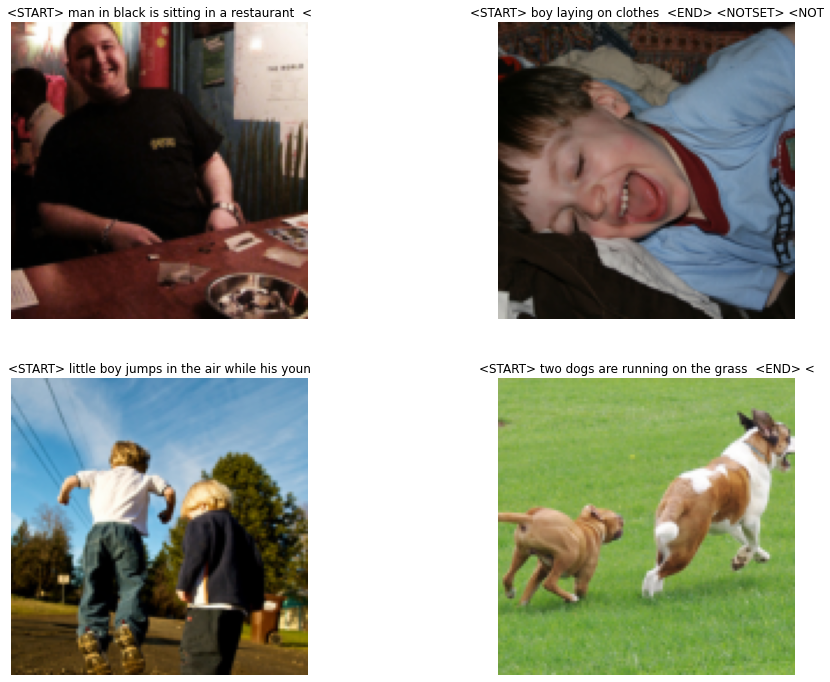

In [22]:
# Plot some examples from the training set
from matplotlib import pyplot as plt

nrows = 2
ncols = 2
plt.figure(figsize=(16, 12))
for i in range(nrows * ncols):
    idx = random.randint(0, len(ds_train)-1)
    im, caption, _, _ = ds_train[idx]
    plt.subplot(nrows, ncols, i+1)
    plt.title(ds_train.decode_caption(caption)[:50])  # TODO: modify this to show the entire caption correctly
    imshow(im)
    plt.axis('off')

### Model initialization and training

In [23]:
# dummy variables
vocab_size = 10000
num_hidden = 512
embedding_dim = 512
batch_size = 128
lr = 0.01

In [25]:
from src.models import EncoderDecoder, LSTMDecoder, get_encoder

encoder = get_encoder(num_hidden)
decoder = LSTMDecoder(num_hidden, embedding_dim, vocab_size, device)
encoder, decoder = encoder.to(device), decoder.to(device)

model = EncoderDecoder(encoder, decoder)
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [26]:
model

EncoderDecoder(
  (encoder): ResNet(
    (pretrained): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): 

In [27]:
optimizer = optim.Adam(model.parameters())

In [28]:
# overfit on a mini dataset
ds_mini = torch.utils.data.Subset(ds_train, [0, 1])

In [29]:
from src.trainer import Trainer, TrainerConfig

config = TrainerConfig(batch_size=128, epochs=100, num_workers=8)
trainer = Trainer(config, model, optimizer, ds_mini, ds_eval)

In [55]:
%pdb
trainer.train()  # overfit on a mini dataset for a quick sanity check

Automatic pdb calling has been turned OFF


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
14/03/2021 23:20:32 - src.trainer - INFO - Epoch 0 - train_loss: 7.4155
14/03/2021 23:20:34 - src.trainer - INFO - Epoch 1 - train_loss: 6.1071
14/03/2021 23:20:35 - src.trainer - INFO - Epoch 2 - train_loss: 4.7085
14/03/2021 23:20:37 - src.trainer - INFO - Epoch 3 - train_loss: 3.3689
14/03/2021 23:20:38 - src.trainer - INFO - Epoch 4 - train_loss: 2.8502
14/03/2021 23:20:40 - src.trainer - INFO - Epoch 5 - train_loss: 2.7351
14/03/2021 23:20:41 - src.trainer - INFO - Epoch 6 - train_loss: 2.5915
14/03/2021 23:20:43 - src.trainer - INFO

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')